In [1]:
# Author ~ Markela Zeneli
# Goldsmiths, University of London
########################################

import pandas as pd
import numpy as np
import os
import fnmatch
import datetime
import math
import matplotlib
import matplotlib.pyplot as plt

#Initialise lists
age = []
gender = []
outcome = []
race = []

race_list = ["Asian", "Black", "Other", "White"]
gender_list = ["Female", "Male"]
age_list = ["10-17", "18-24", "25-34", "over 34"]

#Add CSV columns to respective lists
def all(path):
    '''Appends values from current path into the lists "race", "gender", "outcome", and "age"'''
    global race
    global gender
    global outcome
    global age
    
    df = pd.read_csv(path, sep=',')

    df['Officer-defined ethnicity'].replace('', np.nan, inplace=True)
    df['Gender'].replace('', np.nan, inplace=True)
    df['Outcome'].replace('', np.nan, inplace=True)
    df['Age range'].replace('', np.nan, inplace=True)

    ##DropN/A used when conditioning on specific variables (e.g age)
    df.dropna(subset=['Officer-defined ethnicity','Gender','Outcome','Age range'], axis = 0, how = "any", inplace = True)

    race += df['Officer-defined ethnicity'].tolist()
    gender +=df['Gender'].tolist()
    outcome += df['Outcome'].tolist()
    age += df['Age range'].tolist()

#Populates the lists in the "all" function with the summative data between month1 year1 and month2 year2
def getDates(month1, year1, month2, year2):
    '''This function calls the "all" function above, summating data from a pre-specified start date and end date. It calls "all" on both City of London and Metropolitan police data.'''
    #If operating on a month-by-month basis
    if month1==month2 and year1==year2:
        if month1<10:
            #Populate the Stop and Search demographics lists for Metropolitan and City of London
            all('data/'+str(year1)+'-0'+str(month1)+'/'+str(year1)+'-0'+str(month1)+'-city-of-london-stop-and-search.csv')
            all('data/'+str(year1)+'-0'+str(month1)+'/'+str(year1)+'-0'+str(month1)+'-metropolitan-stop-and-search.csv')
        else:
            all('data/'+str(year1)+'-'+str(month1)+'/'+str(year1)+'-'+str(month1)+'-city-of-london-stop-and-search.csv')
            all('data/'+str(year1)+'-'+str(month1)+'/'+str(year1)+'-'+str(month1)+'-metropolitan-stop-and-search.csv')

    #If summating data for multiple month intervals
    else:
        #Start date
        d = datetime.date(year1,month1,15)

        #Size of each step
        month_delta = datetime.timedelta(days=30)

        #End date
        end_date = datetime.date(year2,month2,15)
        #print(end_date)

        #Calculates difference in dates (by metric of .days), and turns into months by dividing by 30 and rounding up
        for i in range(math.ceil(((end_date - d).days)/30)):
            #File paths for months with 1 digit (adds a 0 in front to keep in line with format of file path)
            if (d + i*month_delta).month < 10:
                #Populate the Stop and Search demographics lists for Metropolitan and City of London (adds a zero in front if month is a single digit)
                all('data/'+str((d + i*month_delta).year)+'-0'+str((d + i*month_delta).month)+'/'+str((d + i*month_delta).year)+'-0'+str((d + i*month_delta).month)+'-city-of-london-stop-and-search.csv')
                all('data/'+str((d + i*month_delta).year)+'-0'+str((d + i*month_delta).month)+'/'+str((d + i*month_delta).year)+'-0'+str((d + i*month_delta).month)+'-metropolitan-stop-and-search.csv')
            else:
                #Populate lists if months >= 10
                all('data/'+str((d + i*month_delta).year)+'-'+str((d + i*month_delta).month)+'/'+str((d + i*month_delta).year)+'-'+str((d + i*month_delta).month)+'-city-of-london-stop-and-search.csv')
                all('data/'+str((d + i*month_delta).year)+'-'+str((d + i*month_delta).month)+'/'+str((d + i*month_delta).year)+'-'+str((d + i*month_delta).month)+'-metropolitan-stop-and-search.csv')

In [2]:
#Time range of CSVs
month1=4
year1=2018
month2=11
year2=2020
#Increment placeholder
month3=0
year3=year1

#STORES
e_disparity = [[1] * (len(race_list)+1) for i in range(32)]
e_innocence = [[1] * (len(race_list)) for i in range(32)]

a_disparity = [[1] * (len(age_list)+1) for i in range(32)]
a_innocence = [[1] * (len(age_list)) for i in range(32)]

g_disparity = [[1] * (len(gender_list)+1) for i in range(32)]
g_innocence = [[1] * (len(gender_list)) for i in range(32)]


#Month count from 0 to 31 (32 months in total)
month_c = 0

In [3]:
def dateIterator(increment):
    '''This function iterates through the timeline of the dataset at a specified increment. It will call the "getDates" function at each increment, and store the summarised statistics before moving onto the next increment.'''
    global month1, year1, month2, year2, month3, year3, race, age, gender, outcome, month_c

    #Special-case flag for when month1 = 1 and increment = 1
    flag = False

    #While the start of each increment is before the end date
    while ((month1 <= month2 and year1 <= year2) or (month2 < month1 and year1 < year2)):

        #Add increment to a temp month, "month3". This is the temporary end date.
        month3 = month1 + increment - 1

        #If temp month exceeds 12 (i.e goes into the next year), update temp date accordingly
        if month3 > 12:
            year3 = year1 + 1
            month3 = month3 % 12

        #If temporary end date date exceeds final end date, run "getDates" with final end date instead, then quit the function
        if ((month2 < month3 and year2 <= year3) or (month3 < month2 and year2 < year3)):
            getDates(month1, year1, month2, year2)
            quit()
            
        #Call "getDates" with start date and temporary end date
        getDates(month1, year1, month3, year3)
        
        #Add data from generic "race" list to "e_disparity" and "e_innocence"
        for i in range(len(race)):
            if race[i] == race_list[0]:
                e_disparity[month_c][0] += 1 
            if race[i] == race_list[1]:
                e_disparity[month_c][1] += 1
            if race[i] == race_list[2]:
                e_disparity[month_c][2] += 1
            if race[i] == race_list[3]:
                e_disparity[month_c][3] += 1
        
        e_disparity[month_c][4] = len(race)

        count0 = 0
        count1 = 0
        count2 = 0
        count3 = 0

        # By conditioning on the outcome being "A no further action disposal", the false positive rates on average towards each ethnicity / race are measured. That is, the variance in accuracy with respects to ethnicity.
        for i in range(len(race)):
            if race[i] == race_list[0]:
                if outcome[i] == "A no further action disposal":
                    count0 += 1
            if race[i] == race_list[1]:
                if outcome[i] == "A no further action disposal":
                    count1 += 1
            if race[i] == race_list[2]:
                if outcome[i] == "A no further action disposal":
                    count2 += 1
            if race[i] == race_list[3]:
                if outcome[i] == "A no further action disposal":
                    count3 += 1


        e_innocence[month_c][0] = count0 / e_disparity[month_c][0]
        e_innocence[month_c][1] = count1 / e_disparity[month_c][1]
        e_innocence[month_c][2] = count2 / e_disparity[month_c][2]
        e_innocence[month_c][3] = count3 / e_disparity[month_c][3]

        count0 = 0
        count1 = 0
        count2 = 0
        count3 = 0

        # Add data from age list to "a_disparity"
        for i in range (len(age)):
            if age[i] == age_list[0]:
                a_disparity[month_c][0] += 1
            if age[i] == age_list[1]:
                a_disparity[month_c][1] += 1
            if age[i] == age_list[2]:
                a_disparity[month_c][2] += 1
            if age[i] == age_list[3]:
                a_disparity[month_c][3] += 1
            
        a_disparity[month_c][4] = len(age)

        count0 = 0
        count1 = 0
        count2 = 0
        count3 = 0

        for i in range(len(age)):
            if age[i] == age_list[0]:
                if outcome[i] == "A no further action disposal":
                    count0 += 1
            if age[i] == age_list[1]:
                if outcome[i] == "A no further action disposal":
                    count1 += 1
            if age[i] == age_list[2]:
                if outcome[i] == "A no further action disposal":
                    count2 += 1
            if age[i] == age_list[3]:
                if outcome[i] == "A no further action disposal":
                    count3 += 1


        a_innocence[month_c][0] = count0 / a_disparity[month_c][0]
        a_innocence[month_c][1] = count1 / a_disparity[month_c][1]
        a_innocence[month_c][2] = count2 / a_disparity[month_c][2]
        a_innocence[month_c][3] = count3 / a_disparity[month_c][3]

        count0 = 0
        count1 = 0
        count2 = 0
        count3 = 0

        for i in range (len(gender)):
            if gender[i] == gender_list[0]:
                g_disparity[month_c][0] += 1
            if gender[i] == gender_list[1]:
                g_disparity[month_c][1] += 1

        g_disparity[month_c][2] = len(gender)
        
        count0 = 0
        count1 = 0
      
        for i in range (len(gender)):
            if gender[i] == gender_list[0] and outcome[i] == "A no further action disposal":
                count0 += 1
            if gender[i] == gender_list[1] and outcome[i] == "A no further action disposal":
                count1 += 1
        
        g_innocence[month_c][0] = count0 / g_disparity[month_c][0]
        g_innocence[month_c][1] = count1 / g_disparity[month_c][1]


        # #Stop and search demographics stat
        # for i in range(len(outcome)):
        #     if outcome[i]: #== "White" and gender[i] == "Male" and (age[i] == "10-17" or age[i] == "18-24"):
        #         count1+=1
        #         #if outcome[i] == "A no further action disposal"  :
        #             #count2+=1
        # #"""+geography=fixed for count2"""

        # Increment for e_disparity, e_innocence etc
        month_c += 1

        #Reset lists and variables
        race = []
        gender = []
        outcome = []
        age = []

        #Check if new start date (month3+1) exceeds 12 month scale, and update accordingly if so
        if month3+1 > 12:
            year3 = year1 + 1
            month3 = (month3 + 1) % 12 
            flag = True
        
        #Update start date to new values
        year1 = year3
        if (month3 == 1) and (increment == 1) and flag == True:
            month1 = month3
            flag = False
        else:
            month1 = month3+1

#Call dateIterator with chosen increment
dateIterator(1)

#print(e_innocence)

In [4]:
e_disparity = np.array(e_disparity)
e_innocence = np.array(e_innocence)

a_disparity = np.array(a_disparity)
a_innocence = np.array(a_innocence)

g_disparity = np.array(g_disparity)
g_innocence = np.array(g_innocence)

print(e_disparity[:,2])
print(a_disparity[:,2])

[ 447  362  348  285  427  413  472  495  610  671  627  961  711  744
  766  906  721  769  946  994  745 1233  889  939 1284 1880 1146 1063
  917  825 1024 1201]
[ 2790  2614  2292  2206  3106  2610  2756  3427  3618  3947  4035  5783
  4552  4370  4743  5082  5325  4672  4431  4520  4115  5925  4852  4897
  7671 10122  6385  5802  4492  4249  5245  5857]


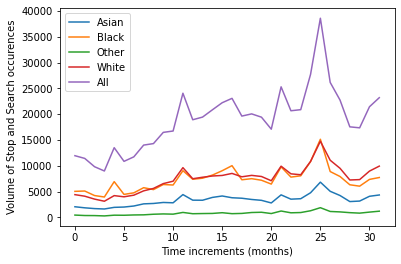

In [5]:
#Plot e_disparity as line graphs
x = range(32)
y0 = e_disparity[:,0]
y1 = e_disparity[:,1]
y2 = e_disparity[:,2]
y3 = e_disparity[:,3]
y4 = e_disparity[:,4]

plt.plot(x, y0, label = "Asian")
plt.plot(x, y1, label = "Black")
plt.plot(x, y2, label = "Other")
plt.plot(x, y3, label = "White")
plt.plot(x, y4, label = "All")

plt.ylabel('Volume of Stop and Search occurences')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

Big spike in the 25th month (May 2020). 

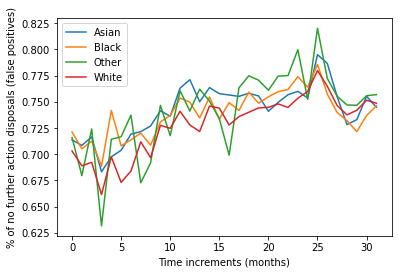

In [13]:
#Plot e_innocence as line graphs
x = range(32)
y0 = e_innocence[:,0]
y1 = e_innocence[:,1]
y2 = e_innocence[:,2]
y3 = e_innocence[:,3]

plt.plot(x, y0, label = "Asian")
plt.plot(x, y1, label = "Black")
plt.plot(x, y2, label = "Other")
plt.plot(x, y3, label = "White")

plt.ylabel('%'+' of no further action disposals (false positives)')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

Same big spike in May 2020. Most likely is what lead to the Guardian article, but Asian people and "Other" were even more likely to be targetted wrongly than Black people. White people were targetted the most appropriately.

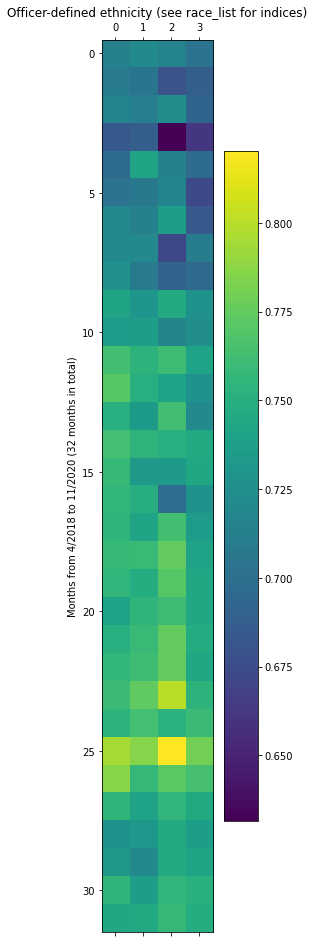

In [7]:
#Visualise e_innocence as 2D colour-coded matrix
plt.matshow(e_innocence)
plt.title('Officer-defined ethnicity (see race_list for indices)')
plt.ylabel('Months from 4/2018 to 11/2020 (32 months in total)')
plt.colorbar()
plt.savefig('output2.png')

In [8]:
#row with small variance and gradual decline
print(e_innocence[14])

[0.76356589 0.75460647 0.75065274 0.74594864]


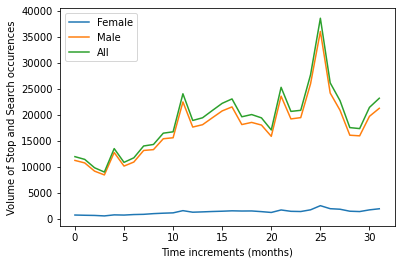

In [9]:
#Plot g_disparity as line graphs
x = range(32)
y0 = g_disparity[:,0]
y1 = g_disparity[:,1]
y2 = g_disparity[:,2]

plt.plot(x, y0, label = "Female")
plt.plot(x, y1, label = "Male")
plt.plot(x, y2, label = "All")

plt.ylabel('Volume of Stop and Search occurences')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

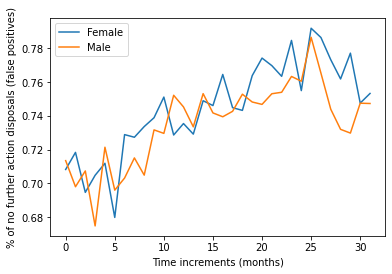

In [10]:
#Plot g_innocence as line graphs
x = range(32)
y0 = g_innocence[:,0]
y1 = g_innocence[:,1]

plt.plot(x, y0, label = "Female")
plt.plot(x, y1, label = "Male")

plt.ylabel('%'+' of no further action disposals (false positives)')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

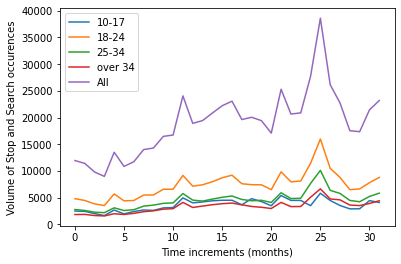

In [11]:
#Plot a_disparity as line graphs
x = range(32)
y0 = a_disparity[:,0]
y1 = a_disparity[:,1]
y2 = a_disparity[:,2]
y3 = a_disparity[:,3]
y4 = a_disparity[:,4]

plt.plot(x, y0, label = "10-17")
plt.plot(x, y1, label = "18-24")
plt.plot(x, y2, label = "25-34")
plt.plot(x, y3, label = "over 34")
plt.plot(x, y4, label = "All")

plt.ylabel('Volume of Stop and Search occurences')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

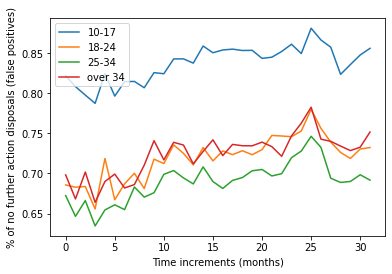

In [12]:
#Plot a_innocence as line graphs
x = range(32)
y0 = a_innocence[:,0]
y1 = a_innocence[:,1]
y2 = a_innocence[:,2]
y3 = a_innocence[:,3]

plt.plot(x, y0, label = "10-17")
plt.plot(x, y1, label = "18-24")
plt.plot(x, y2, label = "25-34")
plt.plot(x, y3, label = "over 34")

plt.ylabel('%'+' of no further action disposals (false positives)')
plt.xlabel('Time increments (months)')
plt.legend()
plt.show()

## Table of stats

These figures were gathered prior to the data cleaning.

KEY: 

(*) - This probability is the number of street crimes reported which are not related to "Anti-social behaviour". This constraint exists because "Anti-social behaviour" can be subjective to the person reporting the crime, and does not always indicate a threat to society. At least, the type of threat which supposedly justifies the volume of Stop and Searches that do occur. Comparing with the "Crimes Reported" data can also be seen as an acknowledgement of the claim that Stop and Searches have a preventative effect on crime. ["The police use these powers to help make the local community safer by preventing and detecting crime."](https://www.met.police.uk/advice/advice-and-information/st-s/stop-and-search/stop-and-search-process/). 

Age = 10-24 --> (age(i) == "10-17" or age(i) == "18-24")

Age = 25+ --> (age(i) != "10-17" and age(i) != "18-24")


TBC

|start date|end date|S+S innocence|S+S volume|Crime*|Crime reported|notes|
|---|---|---|---|---|---|---| 
|12/2017|11/2020|0.76|66245|0.73|2634530|entire dataset, no constraints|
|12/2017|01/2018|0.39|21689|0.81|134974|general stats for pairs of months|
|02/2018|03/2018|0.70|10851|0.82|62536||
|04/2018|05/2018|0.73|12970|0.77|67036||
|06/2018|07/2018|0.72|10673|0.78|70829|| 
|08/2018|09/2018|0.73|27046|0.79|138729|?|
|10/2018|11/2018|0.72|28100|0.79|149038|?|
|12/2018|01/2019|0.74|33780|0.81|143843|?|
|02/2019|03/2019|0.75|18549|0.81|70418||
|04/2019|05/2019|0.76|21003|0.79|73177||
|06/2019|07/2019|0.77|23374|0.77|74689||
|08/2019|09/2019|0.76|49132|0.76|136943||
|10/2019|11/2019|0.77|45225|0.79|150473||
|12/2019|01/2020|0.77|48523|0.81|144107||
|02/2020|03/2020|0.77|23680|0.81|70687||
|04/2020|05/2020|0.77|30733|0.43|47397||
|06/2020|07/2020|0.79|30254|0.61|60890||
|08/2020|09/2020|0.76|40511|0.67|138641||
|10/2020|11/2020|0.77|51723|0.67|132234|end pairs|
|12/2017|01/2018|0.38|3745|0.81|134974|pairs of months, S+S volume given ethnicity = White, age = 10-24|
|02/2018|03/2018|ERR|ERR|0.82|62536||
|04/2018|05/2018|0.72|2115|0.77|67036||
|06/2018|07/2018|0.70|1560|0.78|70829|| 
|08/2018|09/2018|0.69|3589|0.79|138729|?|
|10/2018|11/2018|0.72|4206|0.79|149038|?|
|12/2018|01/2019|0.72|5489|0.81|143843|?|
|02/2019|03/2019|0.73|3166|0.81|70418||
|04/2019|05/2019|0.74|3345|0.79|73177||
|06/2019|07/2019|0.76|3564|0.77|74689||
|08/2019|09/2019|0.75|6987|0.76|136943||
|10/2019|11/2019|0.76|7486|0.79|150473||
|12/2019|01/2020|0.76|7795|0.81|144107||
|02/2020|03/2020|0.77|3997|0.81|70687||
|04/2020|05/2020|0.77|4521|0.43|47397||
|06/2020|07/2020|0.78|4976|0.61|60890||
|08/2020|09/2020|0.75|5902|0.67|138641||
|10/2020|11/2020|0.77|8290|0.67|132234|end pairs|
|12/2017|01/2018|0.37|3712|0.81|134974|pairs of months, S+S volume given ethnicity = White, age = 25+|
|02/2018|03/2018|0.67|3766|0.82|62536||
|04/2018|05/2018|0.70|2063|0.77|67036||
|06/2018|07/2018|0.71|1780|0.78|70829|| 
|08/2018|09/2018|0.69|4118|0.79|138729|?|
|10/2018|11/2018|0.69|4631|0.79|149038|?|
|12/2018|01/2019|0.72|5953|0.81|143843|?|
|02/2019|03/2019|0.73|3497|0.81|70418||
|04/2019|05/2019|0.73|3703|0.79|73177||
|06/2019|07/2019|0.75|4059|0.77|74689||
|08/2019|09/2019|0.74|8655|0.76|136943||
|10/2019|11/2019|0.75|7906|0.79|150473||
|12/2019|01/2020|0.75|8689|0.81|144107||
|02/2020|03/2020|0.75|4235|0.81|70687||
|04/2020|05/2020|0.77|5914|0.43|47397||
|06/2020|07/2020|0.77|5598|0.61|60890||
|08/2020|09/2020|0.75|7812|0.67|138641||
|10/2020|11/2020|0.75|9714|0.67|132234|end pairs|
|12/2017|01/2018|0.39|2152|0.81|134974|pairs of months, S+S volume given ethnicity = Asian, age = 10-24|
|02/2018|03/2018|ERR|ERR|0.82|62536||
|04/2018|05/2018|0.73|1265|0.77|67036||
|06/2018|07/2018|0.73|1049|0.78|70829|| 
|08/2018|09/2018|0.72|2467|0.79|138729|?|
|10/2018|11/2018|0.75|2982|0.79|149038|?|
|12/2018|01/2019|0.75|3436|0.81|143843|?|
|02/2019|03/2019|0.76|1699|0.81|70418||
|04/2019|05/2019|0.79|2000|0.79|73177||
|06/2019|07/2019|0.78|2421|0.77|74689||
|08/2019|09/2019|0.78|4576|0.76|136943||
|10/2019|11/2019|0.78|4187|0.79|150473||
|12/2019|01/2020|0.77|4399|0.81|144107||
|02/2020|03/2020|0.78|2238|0.81|70687||
|04/2020|05/2020|0.77|2697|0.43|47397||
|06/2020|07/2020|0.81|3017|0.61|60890||
|08/2020|09/2020|0.76|3507|0.67|138641||
|10/2020|11/2020|0.77|4691|0.67|132234|end pairs|
|12/2017|01/2018|0.36|1349|0.81|134974|pairs of months, S+S volume given ethnicity = Asian, age = 25+|
|02/2018|03/2018|0.68|1648|0.82|62536||
|04/2018|05/2018|0.72|845|0.77|67036||
|06/2018|07/2018|0.73|673|0.78|70829|| 
|08/2018|09/2018|0.71|1585|0.79|138729|?|
|10/2018|11/2018|0.72|1991|0.79|149038|?|
|12/2018|01/2019|0.75|2404|0.81|143843|?|
|02/2019|03/2019|0.75|1245|0.81|70418||
|04/2019|05/2019|0.78|1504|0.79|73177||
|06/2019|07/2019|0.79|1660|0.77|74689||
|08/2019|09/2019|0.77|3492|0.76|136943||
|10/2019|11/2019|0.78|3135|0.79|150473||
|12/2019|01/2020|0.76|3250|0.81|144107||
|02/2020|03/2020|0.76|1520|0.81|70687||
|04/2020|05/2020|0.77|2319|0.43|47397||
|06/2020|07/2020|0.81|2557|0.61|60890||
|08/2020|09/2020|0.76|3287|0.67|138641||
|10/2020|11/2020|0.78|4389|0.67|132234|end pairs|
|12/2017|01/2018|0.42|4905|0.81|134974|pairs of months, S+S volume given ethnicity = Black, age = 10-24|
|02/2018|03/2018|ERR|ERR|0.82|62536||
|04/2018|05/2018|0.75|3259|0.77|67036||
|06/2018|07/2018|0.74|2701|0.78|70829|| 
|08/2018|09/2018|0.76|7539|0.79|138729|?|
|10/2018|11/2018|0.74|6506|0.79|149038|?|
|12/2018|01/2019|0.75|7052|0.81|143843|?|
|02/2019|03/2019|0.76|3867|0.81|70418||
|04/2019|05/2019|0.78|4751|0.79|73177||
|06/2019|07/2019|0.79|5271|0.77|74689||
|08/2019|09/2019|0.78|11117|0.76|136943||
|10/2019|11/2019|0.78|9513|0.79|150473||
|12/2019|01/2020|0.79|10202|0.81|144107||
|02/2020|03/2020|0.80|4883|0.81|70687||
|04/2020|05/2020|0.79|6164|0.43|47397||
|06/2020|07/2020|0.79|5299|0.61|60890||
|08/2020|09/2020|0.76|7299|0.67|138641||
|10/2020|11/2020|0.77|8929|0.67|132234|end pairs|
|12/2017|01/2018|0.39|3231|0.81|134974|pairs of months, S+S volume given ethnicity = Black, age = 25+|
|02/2018|03/2018|0.72|4131|0.82|62536||
|04/2018|05/2018|0.73|1947|0.77|67036||
|06/2018|07/2018|0.73|1694|0.78|70829|| 
|08/2018|09/2018|0.76|4856|0.79|138729|?|
|10/2018|11/2018|0.73|4516|0.79|149038|?|
|12/2018|01/2019|0.74|5235|0.81|143843|?|
|02/2019|03/2019|0.76|2822|0.81|70418||
|04/2019|05/2019|0.77|3203|0.79|73177||
|06/2019|07/2019|0.76|3579|0.77|74689||
|08/2019|09/2019|0.77|8108|0.76|136943||
|10/2019|11/2019|0.79|6705|0.79|150473||
|12/2019|01/2020|0.78|7753|0.81|144107||
|02/2020|03/2020|0.77|3713|0.81|70687||
|04/2020|05/2020|0.78|5206|0.43|47397||
|06/2020|07/2020|0.79|4681|0.61|60890||
|08/2020|09/2020|0.78|6711|0.67|138641||
|10/2020|11/2020|0.78|7923|0.67|132234|end pairs|
|12/2017|02/2018|0.49|32540|0.81|197510|general stats for every 3 months|
|03/2018|05/2018|0.71|36437|0.79|205996||
|06/2018|08/2018|0.72|35645|0.78|215516||
|09/2018|11/2018|0.72|39878|0.79|218187|| 
|12/2018|02/2019|0.74|52329|0.81|214261|?|
|03/2019|05/2019|0.74|52329|0.79|227782|?|
|06/2019|08/2019|0.76|75363|0.75|217823|?|
|09/2019|11/2019|0.77|67567|0.79|218657|?|
|12/2019|02/2020|0.77|72203|0.81|214794||
|03/2020|05/2020|0.79|98300|0.54|168022||
|06/2020|08/2020|0.77|77015|0.64|198763||
|09/2020|11/2020|0.77|71900|0.68|201487|end triples|
|12/2017|02/2018|0.37|3761|0.81|197510|every 3 months, ethnicity = White, age = 10-24|
|03/2018|05/2018|0.71|4083|0.79|205996||
|06/2018|08/2018|0.69|4670|0.78|215516||
|09/2018|11/2018|0.70|5968|0.79|218187|| 
|12/2018|02/2019|0.73|8655|0.81|214261|early spike|
|03/2019|05/2019|0.75|11212|0.79|227782|SPIKE|
|06/2019|08/2019|0.75|10771|0.75|217823||
|09/2019|11/2019|0.76|10759|0.79|218657||
|12/2019|02/2020|0.77|11792|0.81|214794||
|03/2019|05/2020|0.78|14984|0.54|168022|SPIKE|
|06/2020|08/2020|0.76|11639|0.64|198763||
|09/2020|11/2020|0.77|11372|0.68|201487|end triples|
|12/2017|02/2018|0.52|7478|0.81|197510|every 3 months, ethnicity = White, age = 25+|
|03/2018|05/2018|0.68|7673|0.79|205996||
|06/2018|08/2018|0.69|5563|0.78|215516||
|09/2018|11/2018|0.68|6581|0.79|218187|| 
|12/2018|02/2019|0.72|9450|0.81|214261||
|03/2019|05/2019|0.73|12380|0.79|227782|SPIKE|
|06/2019|08/2019|0.75|12684|0.75|217823||
|09/2019|11/2019|0.74|12120|0.79|218657||
|12/2019|02/2020|0.75|12924|0.81|214794||
|03/2019|05/2020|0.77|17660|0.54|168022|SPIKE|
|06/2020|08/2020|0.75|14699|0.64|198763||
|09/2020|11/2020|0.75|13588|0.68|201487|end triples|
|12/2017|02/2018|0.39|2153|0.81|197510|every 3 months, ethnicity = Asian, age = 10-24|
|03/2018|05/2018|0.72|2439|0.79|205996||
|06/2018|08/2018|0.71|3275|0.78|215516||
|09/2018|11/2018|0.73|4243|0.79|218187|| 
|12/2018|02/2019|0.75|5135|0.81|214261||
|03/2019|05/2019|0.78|6765|0.79|227782|SPIKE|
|06/2019|08/2019|0.78|7311|0.75|217823||
|09/2019|11/2019|0.78|6473|0.79|218657||
|12/2019|02/2020|0.77|6637|0.81|214794||
|03/2019|05/2020|0.79|8853|0.54|168022|SPIKE|
|06/2020|08/2020|0.79|7151|0.64|198763||
|09/2020|11/2020|0.77|6473|0.68|201487|end triples|
|12/2017|02/2018|0.54|2997|0.81|197510|every 3 months, ethnicity = Asian, age = 25+|
|03/2018|05/2018|0.72|3484|0.79|205996||
|06/2018|08/2018|0.71|2126|0.78|215516||
|09/2018|11/2018|0.72|2768|0.79|218187|| 
|12/2018|02/2019|0.75|3649|0.81|214261||
|03/2019|05/2019|0.77|4933|0.79|227782|SPIKE|
|06/2019|08/2019|0.78|5347|0.75|217823||
|09/2019|11/2019|0.78|4816|0.79|218657||
|12/2019|02/2020|0.76|4770|0.81|214794||
|03/2019|05/2020|0.79|7384|0.54|168022|SPIKE|
|06/2020|08/2020|0.78|6354|0.64|198763||
|09/2020|11/2020|0.78|6083|0.68|201487|end triples|
|12/2017|02/2018|0.42|4909|0.81|197510|every 3 months, ethnicity = Black, age = 10-24|
|03/2018|05/2018|0.74|6571|0.79|205996||
|06/2018|08/2018|0.75|9908|0.78|215516||
|09/2018|11/2018|0.74|9296|0.79|218187|| 
|12/2018|02/2019|0.75|10919|0.81|214261||
|03/2019|05/2019|0.77|15386|0.79|227782|SPIKE (after steep incline)|
|06/2019|08/2019|0.78|17768|0.75|217823||
|09/2019|11/2019|0.78|14044|0.79|218657||
|12/2019|02/2020|0.79|15085|0.81|214794||
|03/2019|05/2020|0.80|20259|0.54|168022|SPIKE|
|06/2020|08/2020|0.78|13645|0.64|198763||
|09/2020|11/2020|0.77|12520|0.68|201487|end triples|
|12/2017|02/2018|0.57|7362|0.81|197510|every 3 months, ethnicity = Black, age = 25+|
|03/2018|05/2018|0.71|8065|0.79|205996||
|06/2018|08/2018|0.74|6314|0.78|215516||
|09/2018|11/2018|0.73|6385|0.79|218187|| 
|12/2018|02/2019|0.74|8057|0.81|214261|?|
|03/2019|05/2019|0.77|10416|0.79|227782|? March - May more officers, b/c start of new tax year?|
|06/2019|08/2019|0.77|12346|0.75|217823|?|
|09/2019|11/2019|0.78|10074|0.79|218657|?|
|12/2019|02/2020|0.78|11466|0.81|214794||
|03/2019|05/2020|0.80|16340|0.54|168022|March - May more officers, b/c start of new tax year?|
|06/2020|08/2020|0.79|12467|0.64|198763||
|09/2020|11/2020|0.78|11150|0.68|201487|end triples|